<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_VAE/blob/master/2_vae_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder**

Reference: Diederik P. Kingma and Max Welling, “Auto-Encoding Variational Bayes,” arXiv preprint arXiv:1312.6114, 2013.


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Image directory
dir_image = '/content/drive/MyDrive/Colab/Graduation_paper/code_Professor/week2/pic'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Set training parameters**

In [11]:
# Parameters
learning_rate = 1e-3
training_epochs = 50
batch_size = 32
display_step = 5

###**Load MNIST data**
Set train & test data

In [12]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(60000)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(10000)
    .batch(batch_size)
)

In [13]:
dim_x = np.shape(x_train)[1:]
dim_x

(28, 28, 1)

###**Set model**


In [14]:
class VAE(keras.Model):
  """a basic vae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(VAE, self).__init__()
    self.__dict__.update(kwargs)

    self.dim_x_prod = reduce( (lambda x, y: x * y), self.dim_x)

    # Set network
    self.enc_nn = keras.Sequential(self.enc_desc)
    self.dec_nn = keras.Sequential(self.dec_desc)

  def encode(self, x):
    mu, sigma_ = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
    sigma = keras.backend.softplus(sigma_) + 1e-6
    return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

  def decode(self, z):
    return self.dec_nn(z)

  def reconstruct(self, x):
      mu, _ = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
      return self.decode(mu)

  @tf.function
  def compute_loss(self, x):
    q_z = self.encode(x)
    z = q_z.sample()
    x_recon = self.decode(z)

    # Compute KL-divergence
    p_z = ds.MultivariateNormalDiag(
        loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )
    kl_div = ds.kl_divergence(q_z, p_z)
    loss_latent = tf.reduce_mean(tf.maximum(kl_div, 0))

    # Compute reconstruction loss
    _diffsq_x = tf.math.square(x - x_recon)
    diffsq_x = tf.reshape(_diffsq_x, [-1, self.dim_x_prod])
    _loss_recon = tf.reduce_sum(diffsq_x, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(x)
        loss_sum = loss_latent + loss_recon
    cg = tape.gradient(loss_sum, self.enc_nn.trainable_variables + 
                       self.dec_nn.trainable_variables)
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    cg, loss_latent, loss_recon = self.compute_gradients(x)
    self.optimizer.apply_gradients(zip(cg, self.enc_nn.trainable_variables + 
                                       self.dec_nn.trainable_variables))
    return loss_latent, loss_recon

In [15]:
dim_z = 2

enc_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
            keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(units=dim_z*2)]

dec_desc = [keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
            keras.layers.Reshape(target_shape=(7, 7, 64)),
            keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid")
            ]

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [16]:
vae = VAE(dim_x=dim_x, enc_desc=enc_desc, dec_desc=dec_desc, optimizer=optimizer)

### Train model

In [17]:
# Test-data for plot
test_data_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, nex=6, zm=2, epoch=0):
  x_recon = model.reconstruct(x)
  x_sample = model.decode(tf.random.normal(shape=(batch_size, dim_z)))
  
  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  for axi, (dat, lab) in enumerate(zip([x, x_recon, x_sample],
                                       ["data", "data_recon", "data_sample"],)):
    for ex in range(nex):
      axs[axi, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi, ex].axes.get_xaxis().set_ticks([])
      axs[axi, ex].axes.get_yaxis().set_ticks([])
      axs[axi, 0].set_ylabel(lab)

  plt.show()
  
  # Save fig
  figname2save = '{:s}/train_vae_new_z_{:d}_{:d}.png'.format(dir_image,dim_z,epoch)
  fig.savefig(figname2save)

  # Close fig
  plt.close()

In [18]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 1, Train-Loss: [2.5871,44.8287], Test-Loss: [3.7777,38.0326]


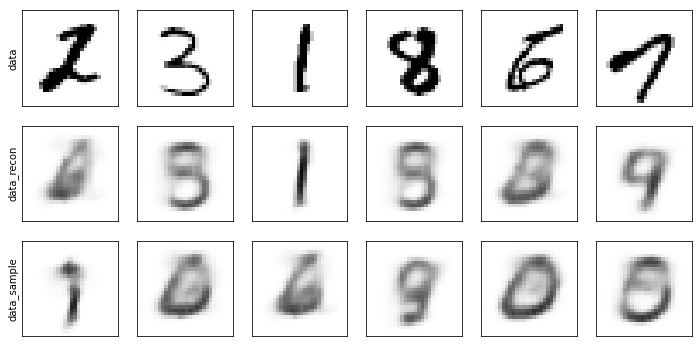

Epoch 2, Train-Loss: [3.8865,36.8771], Test-Loss: [4.0695,35.9155]
Epoch 3, Train-Loss: [4.1245,35.6946], Test-Loss: [4.3805,34.9713]
Epoch 4, Train-Loss: [4.2524,35.0717], Test-Loss: [4.4692,34.5592]
Epoch 5, Train-Loss: [4.3507,34.6502], Test-Loss: [4.0767,34.9554]
Epoch 6, Train-Loss: [4.3935,34.3696], Test-Loss: [4.4373,34.1918]


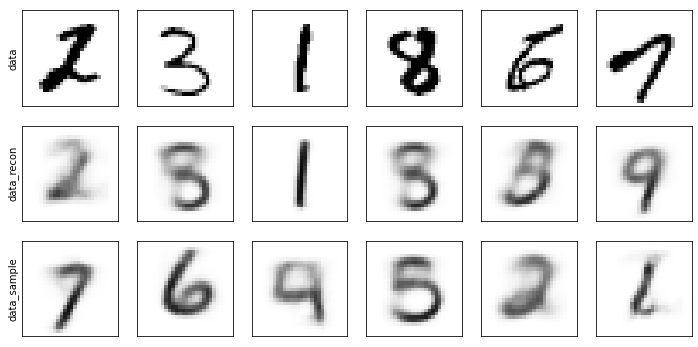

Epoch 7, Train-Loss: [4.4546,34.1134], Test-Loss: [4.5779,33.8209]
Epoch 8, Train-Loss: [4.4949,33.9274], Test-Loss: [4.4346,33.9381]
Epoch 9, Train-Loss: [4.5379,33.7624], Test-Loss: [4.5264,33.8227]
Epoch 10, Train-Loss: [4.5767,33.6188], Test-Loss: [4.5354,33.6096]
Epoch 11, Train-Loss: [4.5808,33.5027], Test-Loss: [4.4745,34.0572]


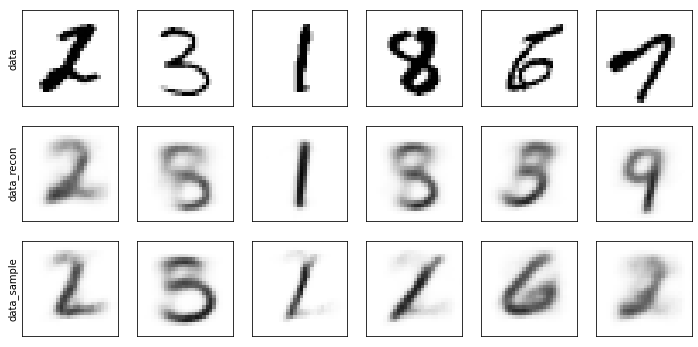

Epoch 12, Train-Loss: [4.6156,33.3978], Test-Loss: [4.7067,33.2785]
Epoch 13, Train-Loss: [4.6355,33.3136], Test-Loss: [4.6441,33.5032]
Epoch 14, Train-Loss: [4.6601,33.2209], Test-Loss: [4.6616,33.4979]
Epoch 15, Train-Loss: [4.6731,33.1692], Test-Loss: [4.6186,33.3335]
Epoch 16, Train-Loss: [4.6848,33.1000], Test-Loss: [4.6897,33.3342]


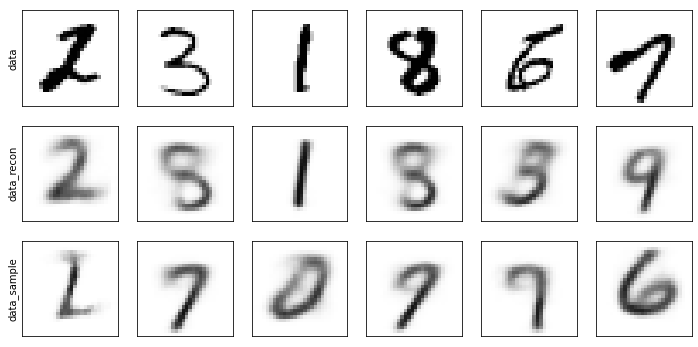

Epoch 17, Train-Loss: [4.6880,33.0379], Test-Loss: [4.7614,33.0668]
Epoch 18, Train-Loss: [4.7101,32.9862], Test-Loss: [4.7939,32.9856]
Epoch 19, Train-Loss: [4.7269,32.9349], Test-Loss: [4.6840,33.2545]
Epoch 20, Train-Loss: [4.7390,32.8927], Test-Loss: [4.6142,33.2347]
Epoch 21, Train-Loss: [4.7559,32.8218], Test-Loss: [4.8007,32.9378]


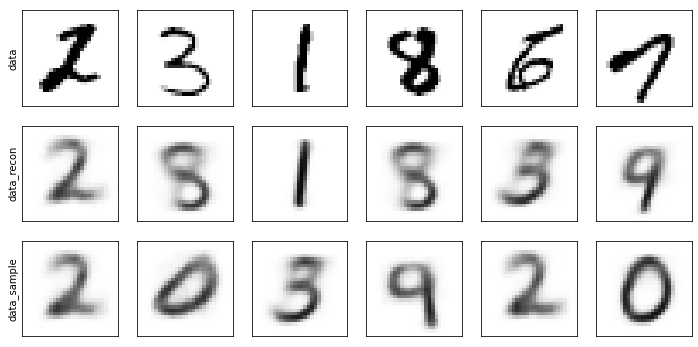

Epoch 22, Train-Loss: [4.7500,32.7794], Test-Loss: [4.8642,33.1173]
Epoch 23, Train-Loss: [4.7576,32.7513], Test-Loss: [4.7031,33.0591]
Epoch 24, Train-Loss: [4.7683,32.7061], Test-Loss: [4.9017,32.8381]
Epoch 25, Train-Loss: [4.7764,32.6521], Test-Loss: [4.6983,33.0050]
Epoch 26, Train-Loss: [4.7888,32.6361], Test-Loss: [4.8976,32.9514]


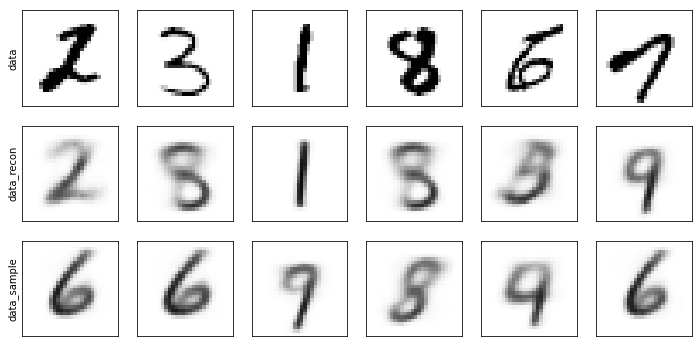

Epoch 27, Train-Loss: [4.7977,32.5832], Test-Loss: [4.8607,33.0061]
Epoch 28, Train-Loss: [4.7987,32.5619], Test-Loss: [4.8269,32.8321]
Epoch 29, Train-Loss: [4.8181,32.5272], Test-Loss: [4.7541,32.9409]
Epoch 30, Train-Loss: [4.8161,32.4945], Test-Loss: [4.8006,32.8922]
Epoch 31, Train-Loss: [4.8315,32.4973], Test-Loss: [4.9128,32.8079]


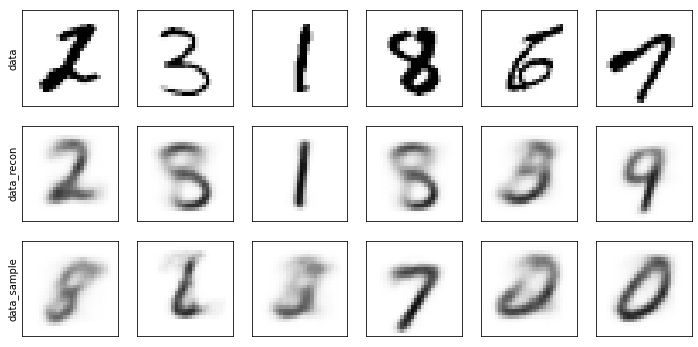

Epoch 32, Train-Loss: [4.8307,32.4536], Test-Loss: [4.9214,32.6562]
Epoch 33, Train-Loss: [4.8486,32.4195], Test-Loss: [4.7726,32.9592]
Epoch 34, Train-Loss: [4.8416,32.4036], Test-Loss: [4.9562,32.8111]
Epoch 35, Train-Loss: [4.8469,32.3795], Test-Loss: [4.6738,32.9967]
Epoch 36, Train-Loss: [4.8663,32.3686], Test-Loss: [4.9795,32.5755]


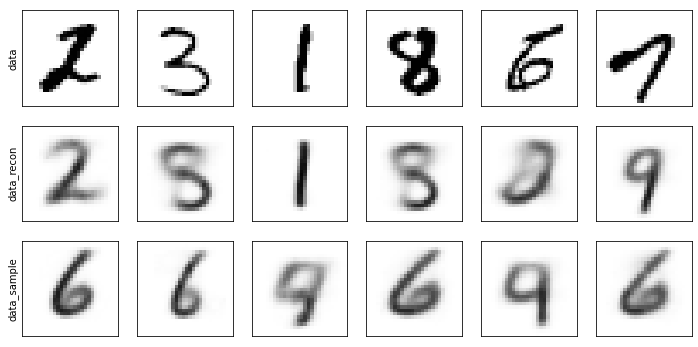

Epoch 37, Train-Loss: [4.8687,32.3306], Test-Loss: [4.9148,32.7809]
Epoch 38, Train-Loss: [4.8730,32.2934], Test-Loss: [4.9737,32.6086]
Epoch 39, Train-Loss: [4.8592,32.3032], Test-Loss: [4.8727,32.6975]
Epoch 40, Train-Loss: [4.8792,32.2680], Test-Loss: [4.8277,32.6541]
Epoch 41, Train-Loss: [4.8704,32.2596], Test-Loss: [4.8283,32.9068]


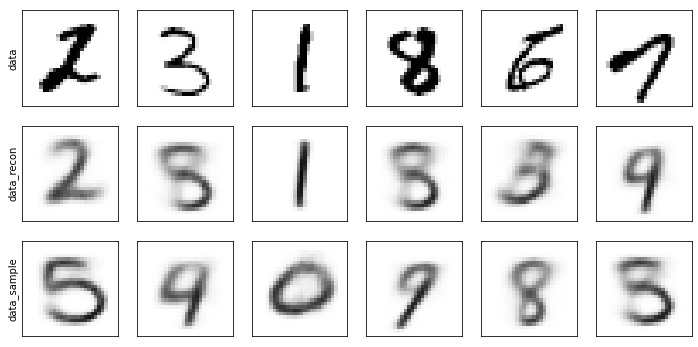

Epoch 42, Train-Loss: [4.8871,32.2183], Test-Loss: [4.8915,32.6830]
Epoch 43, Train-Loss: [4.8851,32.2215], Test-Loss: [4.7618,32.7941]
Epoch 44, Train-Loss: [4.8912,32.1968], Test-Loss: [4.8686,32.8144]
Epoch 45, Train-Loss: [4.9046,32.1693], Test-Loss: [4.8177,32.7091]
Epoch 46, Train-Loss: [4.9008,32.1597], Test-Loss: [4.8670,32.5942]


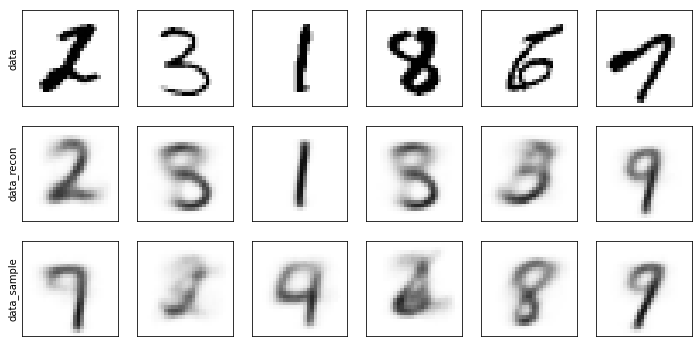

Epoch 47, Train-Loss: [4.9140,32.1635], Test-Loss: [5.0989,32.4195]
Epoch 48, Train-Loss: [4.9103,32.1498], Test-Loss: [4.9295,32.5825]
Epoch 49, Train-Loss: [4.9193,32.1181], Test-Loss: [4.8486,32.7698]
Epoch 50, Train-Loss: [4.9127,32.1176], Test-Loss: [4.9530,32.5765]


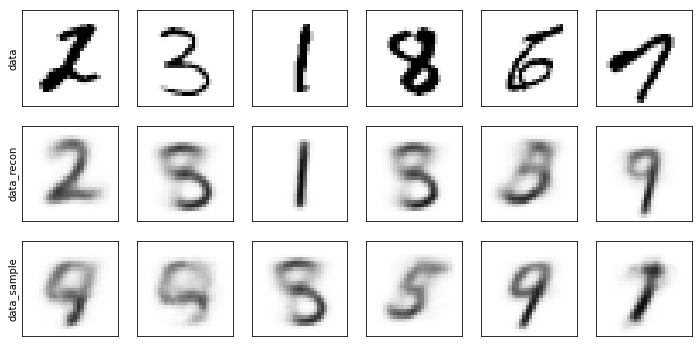

In [19]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    loss_latent, loss_recon = vae.train(x_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t in test_data:
    loss_latent_t, loss_recon_t = vae.compute_loss(x_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(vae, test_data_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

### Plot grid in 2D latent space

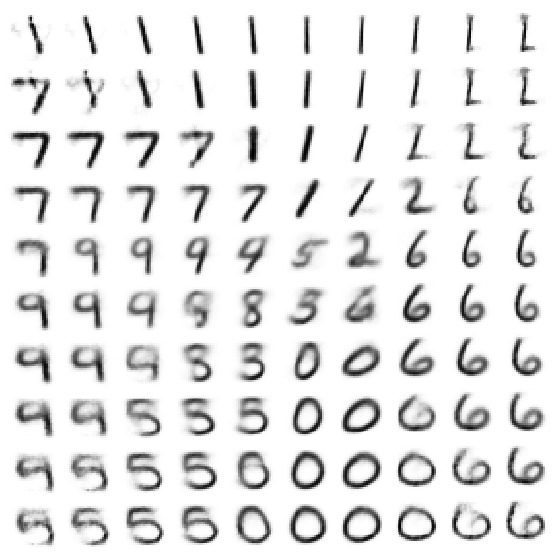

In [20]:
# Sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = vae.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/vae_new_z{:d}_grid.png'.format(dir_image,dim_z)
fig.savefig(figname2save)